# Feature Engineering & Data Transformation — Annie Lin
This notebook performs **feature engineering** and **data transformation** on the cleaned Loan Eligibility dataset. It continues from preprocessing done by `Clean_Loan_Data.py` and validation in `Data_Validation.py`.

**Goals:**
- Encode categorical variables
- Scale numerical variables
- Create new derived features
- Split data into training and validation sets
- Run a baseline logistic regression model

## 1 Setup

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## 2 Load Cleaned Data

In [7]:
train_path = '../data/cleaned/loan_cleaned_train.csv'
test_path = '../data/cleaned/loan_cleaned_test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)
train_df.head()

Train shape: (613, 12)
Test shape: (365, 11)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849.0,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y


## 3 Identify Coumn Types 

In [8]:
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

y_col = 'Loan_Status'

## 4 Encode Categotical Variables

In [9]:
label_enc = LabelEncoder()
for col in ['Gender', 'Married', 'Education', 'Self_Employed']:
    if col in train_df.columns:
        train_df[col] = label_enc.fit_transform(train_df[col])
        test_df[col] = label_enc.transform(test_df[col])

train_df = pd.get_dummies(train_df, columns=['Property_Area'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Property_Area'], drop_first=True)

## 5 Featuer Creation

In [10]:
train_df['Total_Income'] = train_df['ApplicantIncome'] + train_df['CoapplicantIncome']
test_df['Total_Income'] = test_df['ApplicantIncome'] + test_df['CoapplicantIncome']

train_df['Income_to_Loan_Ratio'] = train_df['Total_Income'] / (train_df['LoanAmount'] + 1)
test_df['Income_to_Loan_Ratio'] = test_df['Total_Income'] / (test_df['LoanAmount'] + 1)

train_df['Loan_per_Month'] = train_df['LoanAmount'] / (train_df['Loan_Amount_Term'] + 1)
test_df['Loan_per_Month'] = test_df['LoanAmount'] / (test_df['Loan_Amount_Term'] + 1)

## 6 Feature Scaling 

In [11]:
scaler = StandardScaler()
scale_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
              'Total_Income', 'Income_to_Loan_Ratio', 'Loan_per_Month']

train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

## 7️ Train/Test Split and Save

In [12]:
from sklearn.model_selection import train_test_split
import os

X = train_df.drop(columns=[y_col])
y = train_df[y_col]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

os.makedirs('data/processed', exist_ok=True)
X_train.to_csv('data/processed/X_train.csv', index=False)
X_valid.to_csv('data/processed/X_valid.csv', index=False)
y_train.to_csv('data/processed/y_train.csv', index=False)
y_valid.to_csv('data/processed/y_valid.csv', index=False)

print('✅ Feature engineering complete! Files saved to data/processed/')

✅ Feature engineering complete! Files saved to data/processed/


## 8️ Baseline Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

baseline = LogisticRegression(max_iter=1000)
baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_valid)

print('\nBaseline Logistic Regression Results:')
print('Accuracy:', accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))


Baseline Logistic Regression Results:
Accuracy: 0.8211382113821138
              precision    recall  f1-score   support

           N       0.84      0.54      0.66        39
           Y       0.82      0.95      0.88        84

    accuracy                           0.82       123
   macro avg       0.83      0.75      0.77       123
weighted avg       0.82      0.82      0.81       123



## 9️ Visualizations (Optional- added for visuals)

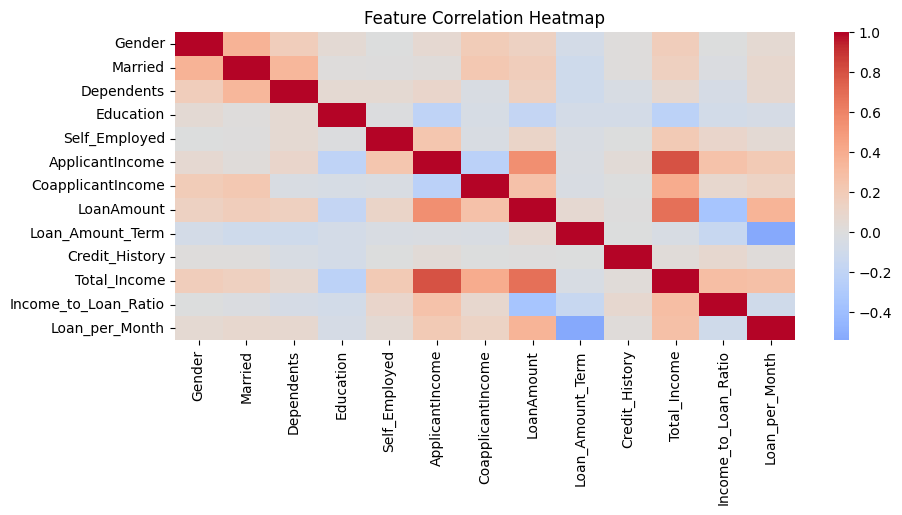

In [15]:
# Only include numeric columns for the correlation heatmap
numeric_df = train_df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 4))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()
